In [123]:
pip install ..

Processing /home/rtrimbou/HuMMuS/hummus_package/hummuspy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hummuspy: filename=hummuspy-0.1.7.post3-py3-none-any.whl size=24130 sha256=6c0450fe1a52a854a41fe179acfed1012b425d799fc955f7a5d8092ced10ffdd
  Stored in directory: /tmp/pip-ephem-wheel-cache-kj_8xg1w/wheels/bb/65/2c/e0f4ac73536045783e0ac23c027c4347c43a62cdb780bc856a
Successfully built hummuspy
  Attempting uninstall: hummuspy
    Found existing installation: hummuspy 0.1.7.post3
    Uninstalling hummuspy-0.1.7.post3:
      Successfully uninstalled hummuspy-0.1.7.post3
Note: you may need to restart the kernel to use updated packages.


In [124]:
import hummuspy as hummus
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

### Load config file

In [125]:
config = hummus.config.open_config("../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/config/config.yml")

In [126]:
hummus.config.check_lamb(config['lamb'], config)

True

In [127]:
config['lamb']

,RNA,TF,peaks
RNA,0.5,0.0,0.5
TF,0.0,0.5,0.0
peaks,0.5,0.5,0.5


### We can draw a graph to illustrate the probability matrix to jump in-between layers

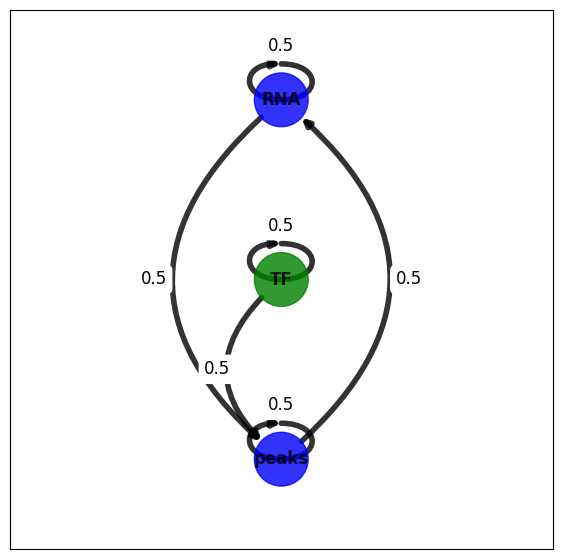

In [128]:
hummus.config.draw_config(config)

_If the order is not suiting you, you can reorganise the columns in 'lamb' parameter_

In [129]:
config['lamb'] = config['lamb'].loc[:, ['TF', 'peaks', 'RNA']]

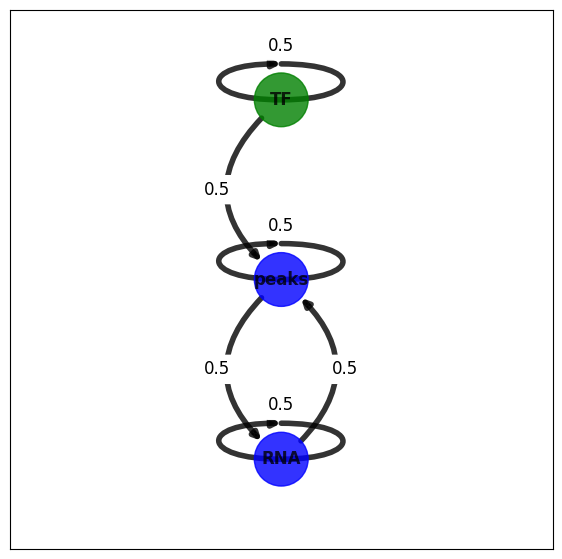

In [130]:
hummus.config.draw_config(config)

 Drawing the default configs for
- GRN
- Enhancers
- Binding regions
- Target genes


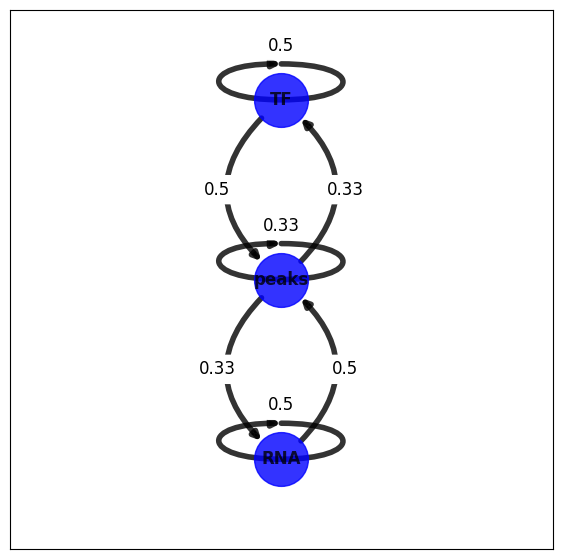

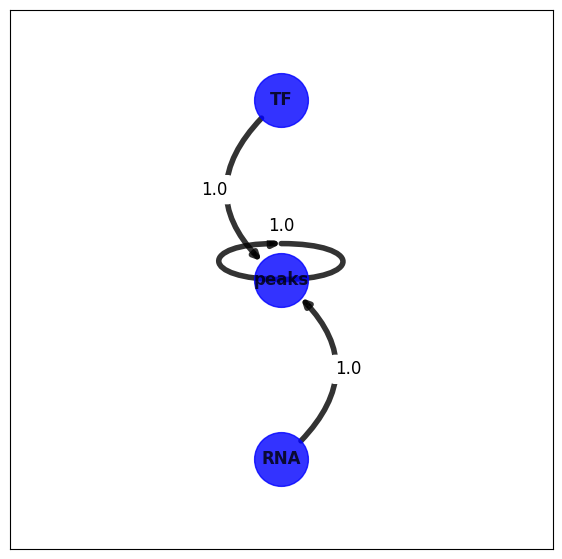

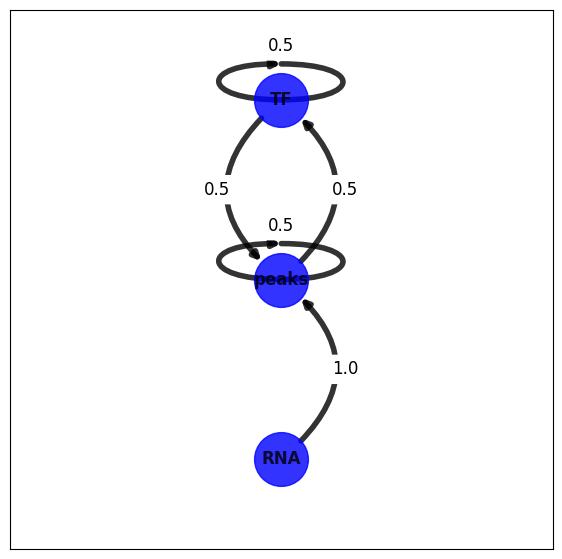

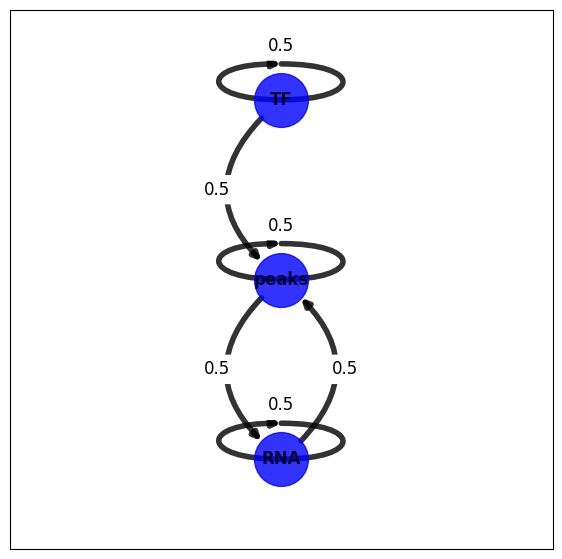

In [131]:
print(' Drawing the default configs for')
print('- GRN')
print('- Enhancers')
print('- Binding regions')
print('- Target genes')

config['lamb'] = hummus.config.get_grn_lamb(config, draw=True)
config['lamb'] = hummus.config.get_enhancers_lamb(config, draw=True)
config['lamb'] = hummus.config.get_binding_regions_lamb(config, draw=True)
config['lamb'] = hummus.config.get_target_genes_lamb(config, draw=True)
#config['lamb'] = hummus.config.get_max_lamb(config, draw=True)  # probability matrix with all possible connexions

## To add new omics, you have to: 
1) Add the new multiplex
2) Add the new bipartite(s)
3) Modify eta (starting) probability
4) Modify lamb (transition) probability

### 1) New multiplex

In [132]:
config['multiplex']

{'RNA': {'graph_type': ['00'], 'layers': ['multiplex/RNA/GENIE3.tsv']},
 'TF': {'graph_type': ['00'], 'layers': ['multiplex/TF/PPI.tsv']},
 'peaks': {'graph_type': ['00'], 'layers': ['multiplex/peaks/Cicero.tsv']}}

**graph_type** is a list of strings containing two binary numbers (0 or 1) that indicates if the networks are weighted and/or directed.<br>
- The first number is directed(1) or not (0)<br>
- The second number is weighted(1) or not (0)<br>
    e.g.: "graph_type": **'01'** is an **undirected and weighted network**

**layers** contain the paths to the different networks composing the multiplex.

There is usually one network only per multiplex, so list of one element each.

In [133]:
config['multiplex']['Proteins'] = {
    'layers': "",
    'graph_type': ""
}

### 2) New bipartite

In [134]:
config['bipartite']

{'bipartite/atac_rna.tsv': {'graph_type': '00',
  'source': 'RNA',
  'target': 'peaks'},
 'bipartite/tf_rna.tsv': {'graph_type': '00',
  'source': 'peaks',
  'target': 'TF'}}

A bipartite is here a single network. You can see that the key is here the path to the network directy and that it contains 3 items:<br>
- **source**: Which indicates the **multiplex** containing the source nodes (the left column)
- **target**: Which indicates the **multiplex** containing the target nodes (the right column)
- **graph_type**: Which indicates if the network is **directed/weighted**, the same way it's used in multiplexes.

In [135]:
config['bipartite']["rna_proteins_path"] = {
    'source': "RNA",
    'target': "Proteins",
    'graph_type': "00"
}

### 3) Modify eta

In [136]:
config['eta']

RNA      0.0
TF       1.0
peaks    0.0
dtype: float64

**eta** is simply a pandas.Series object, that indicates wihat is **the probability to start the random walk from each of the multiplex** <br> (typically a vector of 0s with a single 1 value, for the multiplex containing the type of seeds we use (e.g.: TFs, or genes only)) <br>
**It is defined together with lamb**, depending of the regulations we want to study

In [137]:
# Here an example if we wanted to explore the multilayer from the TFs multiplex
config['eta'] = pd.Series([1, 0, 0, 0], index=['TF', 'peaks', 'RNA', 'Proteins'])
config['eta']

TF          1
peaks       0
RNA         0
Proteins    0
dtype: int64

### 4) Modify lamb

In [138]:
config['lamb']

,RNA,TF,peaks
RNA,0.5,0.0,0.5
TF,0.0,0.5,0.0
peaks,0.5,0.5,0.5


**lamb** is a pandas.Dataframe object, that indicates wihat is **the probability to jump between the multiplexes** <br> (It corresponds to the **very good looking** NetworkX plots, that took me a long time to implement ^^) <br>

**It is defined together with eta**, depending of the regulations we want to study

#### !! lamb[i, j], corresponds to the probability to jump from **j** to **i** !
It is thus normalized per columns. You also need to have a bipartite to allows each non-zero value in lamb.

In [139]:
config['lamb'] = hummus.config.initialise_lamb(config, value=0)

In [140]:
config['lamb']

,RNA,TF,peaks,Proteins
RNA,0.0,0.0,0.0,0.0
TF,0.0,0.0,0.0,0.0
peaks,0.0,0.0,0.0,0.0
Proteins,0.0,0.0,0.0,0.0


In [141]:
# Here we add the probability to go to each layer from another
# Lets imagine the following structure: TF --> peaks <--> RNA <--> Proteins
# If we keep all options equiprobable and without forgetting that we have a probability to STAY in the multiplex:

config['lamb'].loc["TF", "TF"] = 0.5 # probability to go to TF from TF
config['lamb'].loc["peaks", "TF"] = 0.5 # probability to go to peaks from TF

config['lamb'].loc["TF", "peaks"] = 1/3 # probability to go to TF FROM peaks
config['lamb'].loc["peaks", "peaks"] = 1/3 
config['lamb'].loc["RNA", "peaks"] = 1/3 

config['lamb'].loc["peaks", "RNA"] = 1/3  # probability to go to peaks FROM RNA
config['lamb'].loc["RNA", "RNA"] = 1/3 
config['lamb'].loc["Proteins", "RNA"] = 1/3 

config['lamb'].loc["RNA", "Proteins"] = 1/2
config['lamb'].loc["Proteins", "Proteins"] = 1/2


In [142]:
config['lamb']

,RNA,TF,peaks,Proteins
RNA,0.333333,0.0,0.333333,0.5
TF,0.000000,0.5,0.333333,0.0
peaks,0.333333,0.5,0.333333,0.0
Proteins,0.333333,0.0,0.000000,0.5


#### Let's check the whole config after all these modifications !

In [143]:
config

{'bipartite': {'bipartite/atac_rna.tsv': {'graph_type': '00',
   'source': 'RNA',
   'target': 'peaks'},
  'bipartite/tf_rna.tsv': {'graph_type': '00',
   'source': 'peaks',
   'target': 'TF'},
  'rna_proteins_path': {'source': 'RNA',
   'target': 'Proteins',
   'graph_type': '00'}},
 'eta': TF          1
 peaks       0
 RNA         0
 Proteins    0
 dtype: int64,
 'lamb':                RNA   TF     peaks  Proteins
 RNA       0.333333  0.0  0.333333       0.5
 TF        0.000000  0.5  0.333333       0.0
 peaks     0.333333  0.5  0.333333       0.0
 Proteins  0.333333  0.0  0.000000       0.5,
 'multiplex': {'RNA': {'graph_type': ['00'],
   'layers': ['multiplex/RNA/GENIE3.tsv']},
  'TF': {'graph_type': ['00'], 'layers': ['multiplex/TF/PPI.tsv']},
  'peaks': {'graph_type': ['00'], 'layers': ['multiplex/peaks/Cicero.tsv']},
  'Proteins': {'layers': '', 'graph_type': ''}},
 'r': '0.7',
 'seed': 'seeds/seeds.txt',
 'self_loops': '0'}

### Save the config file

We can now save the config file and explore the mutlilayer with this configuration. Usually, I save it in the config folder, itself located in the multilayer_folder (folder containing all the networks, config, etc)

In [144]:
hummus.config.save_config(config, "../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/config/extended_config.yaml")

## Explore the multilayer

We will now use the second module of hummuspy : **hummuspy.explore_network** <br>
The most general functions here are **compute_RandomWalk** and **compute_multiple_RandomWalk**

In [145]:
multilayer_f = "../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/" # the general folder all the files
config_name = "extended_config.yaml" # the beautiful name you chose for your config
list_seeds = [] # Seeds from which we start the exploration. Generally all the nodes from the startin layer, indicated in 'eta' (e.g.: TFs) 

df = hummus.core_grn.define_grn_from_config(
        multilayer_f,
        config,
        "all",
        save=False, # Do we want to save the results on disk
        output_f=None, # Name of the result file IF save on disk
        return_df=True, # return in console the results
                                       # (e.g.: If you're interested only in TF-genes interactions and not in peaks-related scores, put ['RNA']
        njobs=1 # How many cores do you wanna use ?
)

AssertionError: There seem to be a incoherence between bipartite source/targets and multiplex namesprovided in get_classic_grn_lamb

In [1]:
import hummuspy as hummus
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

IndentationError: unexpected indent (create_multilayer.py, line 726)

### Load config file

In [2]:
config = hummus.config.open_config("../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/config/config.yml")
config["eta"] = pd.Series([1, 0, 0], index=['RNA', 'TF', 'peaks'])

In [3]:
# open tf network
genes = pd.read_csv("../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/multiplex/RNA/GENIE3.tsv", sep="\t", header=None)
genes = list(genes[1].unique())


In [4]:
config = hummus.config.process_config(config, multilayer_folder="../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/")
config['seeds']+=genes # list(TFs) #["ARID3A", "ARID3B", "ARID2", "CLOCK", "ARNT2"]

In [5]:
df = hummus.explore_network.compute_multiple_RandomWalk(
    **config,
    save=False,
    n_jobs=4
)
df


RNA_1
Opening network from ../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/multiplex/RNA/GENIE3.tsv.


TF_1
Opening network from ../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/multiplex/TF/PPI.tsv.
peaks_1
Opening network from ../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/multiplex/peaks/Cicero.tsv.
Opening network from ../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/bipartite/atac_rna.tsv.
Opening network from ../../../../HuMMuS/hummus_package/vignettes/test_multiplex_genes/bipartite/tf_rna.tsv.
http://127.0.0.1:8787/status


Running RWR per seed:  10%|█         | 210/2000 [01:23<16:52,  1.77it/s]2025-05-14 15:42:20,216 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p1288'}, 'attr': 'start', 'new': -737.7450466156006}, {'kind': 'ModelChanged', 'model': {'id': 'p1288'}, 'attr': 'end', 'new': 45084.78752708435}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/rtrimbou/miniconda3/envs/hummuspy_recent/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/rtrimbou/miniconda3/envs/hummuspy_recent/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/rtrimbou/miniconda3/envs/hummuspy_recent/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session i

,index,layer,target,path_layer,score,seed
0,1775,RNA,DCAF6,RNA_1,7.190492e-01,DCAF6
1,1746,RNA,DAB1,RNA_1,7.190492e-01,ANKRD54
2,83,RNA,ACACA,RNA_1,7.190492e-01,ATP2C1
3,146,RNA,ADAMTS19,RNA_1,7.190492e-01,ADAMTS19
4,129,RNA,ACTR6,RNA_1,7.190492e-01,AADAT
...,...,...,...,...,...,...
7259995,1622,peaks,chr16-30571413-30572326,peaks_1,4.442934e-15,ADGRL2
7259996,1617,peaks,chr16-30378131-30379136,peaks_1,4.442932e-15,BAX
7259997,1622,peaks,chr16-30571413-30572326,peaks_1,4.442932e-15,BAX
7259998,1622,peaks,chr16-30571413-30572326,peaks_1,4.442930e-15,ATP5H


In [6]:
len(df["seed"].unique())

2000

In [ ]:
pip install ..

Processing /home/rtrimbou/HuMMuS/hummus_package/hummuspy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hummuspy: filename=hummuspy-0.1.4-py3-none-any.whl size=23293 sha256=8d45cfad269b40c2d40805813cefa363ac1cba66a4bfbc614d0bf7c0a0558ebd
  Stored in directory: /tmp/pip-ephem-wheel-cache-1goxahj2/wheels/bb/65/2c/e0f4ac73536045783e0ac23c027c4347c43a62cdb780bc856a
Successfully built hummuspy
  Attempting uninstall: hummuspy
    Found existing installation: hummuspy 0.1.4
    Uninstalling hummuspy-0.1.4:
      Successfully uninstalled hummuspy-0.1.4
Note: you may need to restart the kernel to use updated packages.
